In [25]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pylab as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import precision_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


df1=pd.read_csv('data/timeline_BRONZE_15.csv')
print(df1.shape)
df2=pd.read_csv('data/timeline_DIAMOND_15.csv')
print(df2.shape)

# combine two dataset
df = pd.concat([df1, df2], ignore_index=True)
print(df.shape)
df.head()
df.dtypes

(41601, 55)
(75089, 55)
(116690, 55)


id                     int64
duration               int64
blue_gold              int64
red_gold               int64
gold_diff              int64
blue_xp                int64
red_xp                 int64
xp_diff                int64
blue_ward_placed       int64
red_ward_placed        int64
ward_placed_diff       int64
blue_ward_destroyed    int64
red_ward_destroyed     int64
ward_destroyed_diff    int64
first_blood            int64
blue_kills             int64
red_kills              int64
kill_diff              int64
first_turret           int64
blue_turrets           int64
red_turrets            int64
turret_diff            int64
first_inhibitor        int64
blue_inhibitors        int64
red_inhibitors         int64
inhibitor_diff         int64
first_herald           int64
blue_heralds           int64
red_heralds            int64
herald_diff            int64
first_baron            int64
blue_barons            int64
red_barons             int64
baron_diff             int64
blue_air      

## EDA

### 1. Correlation matrix

In [4]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

y=df['blue_win']
X = df.drop(columns=['id','duration','blue_win','air','hextech','fire','earth','water'])

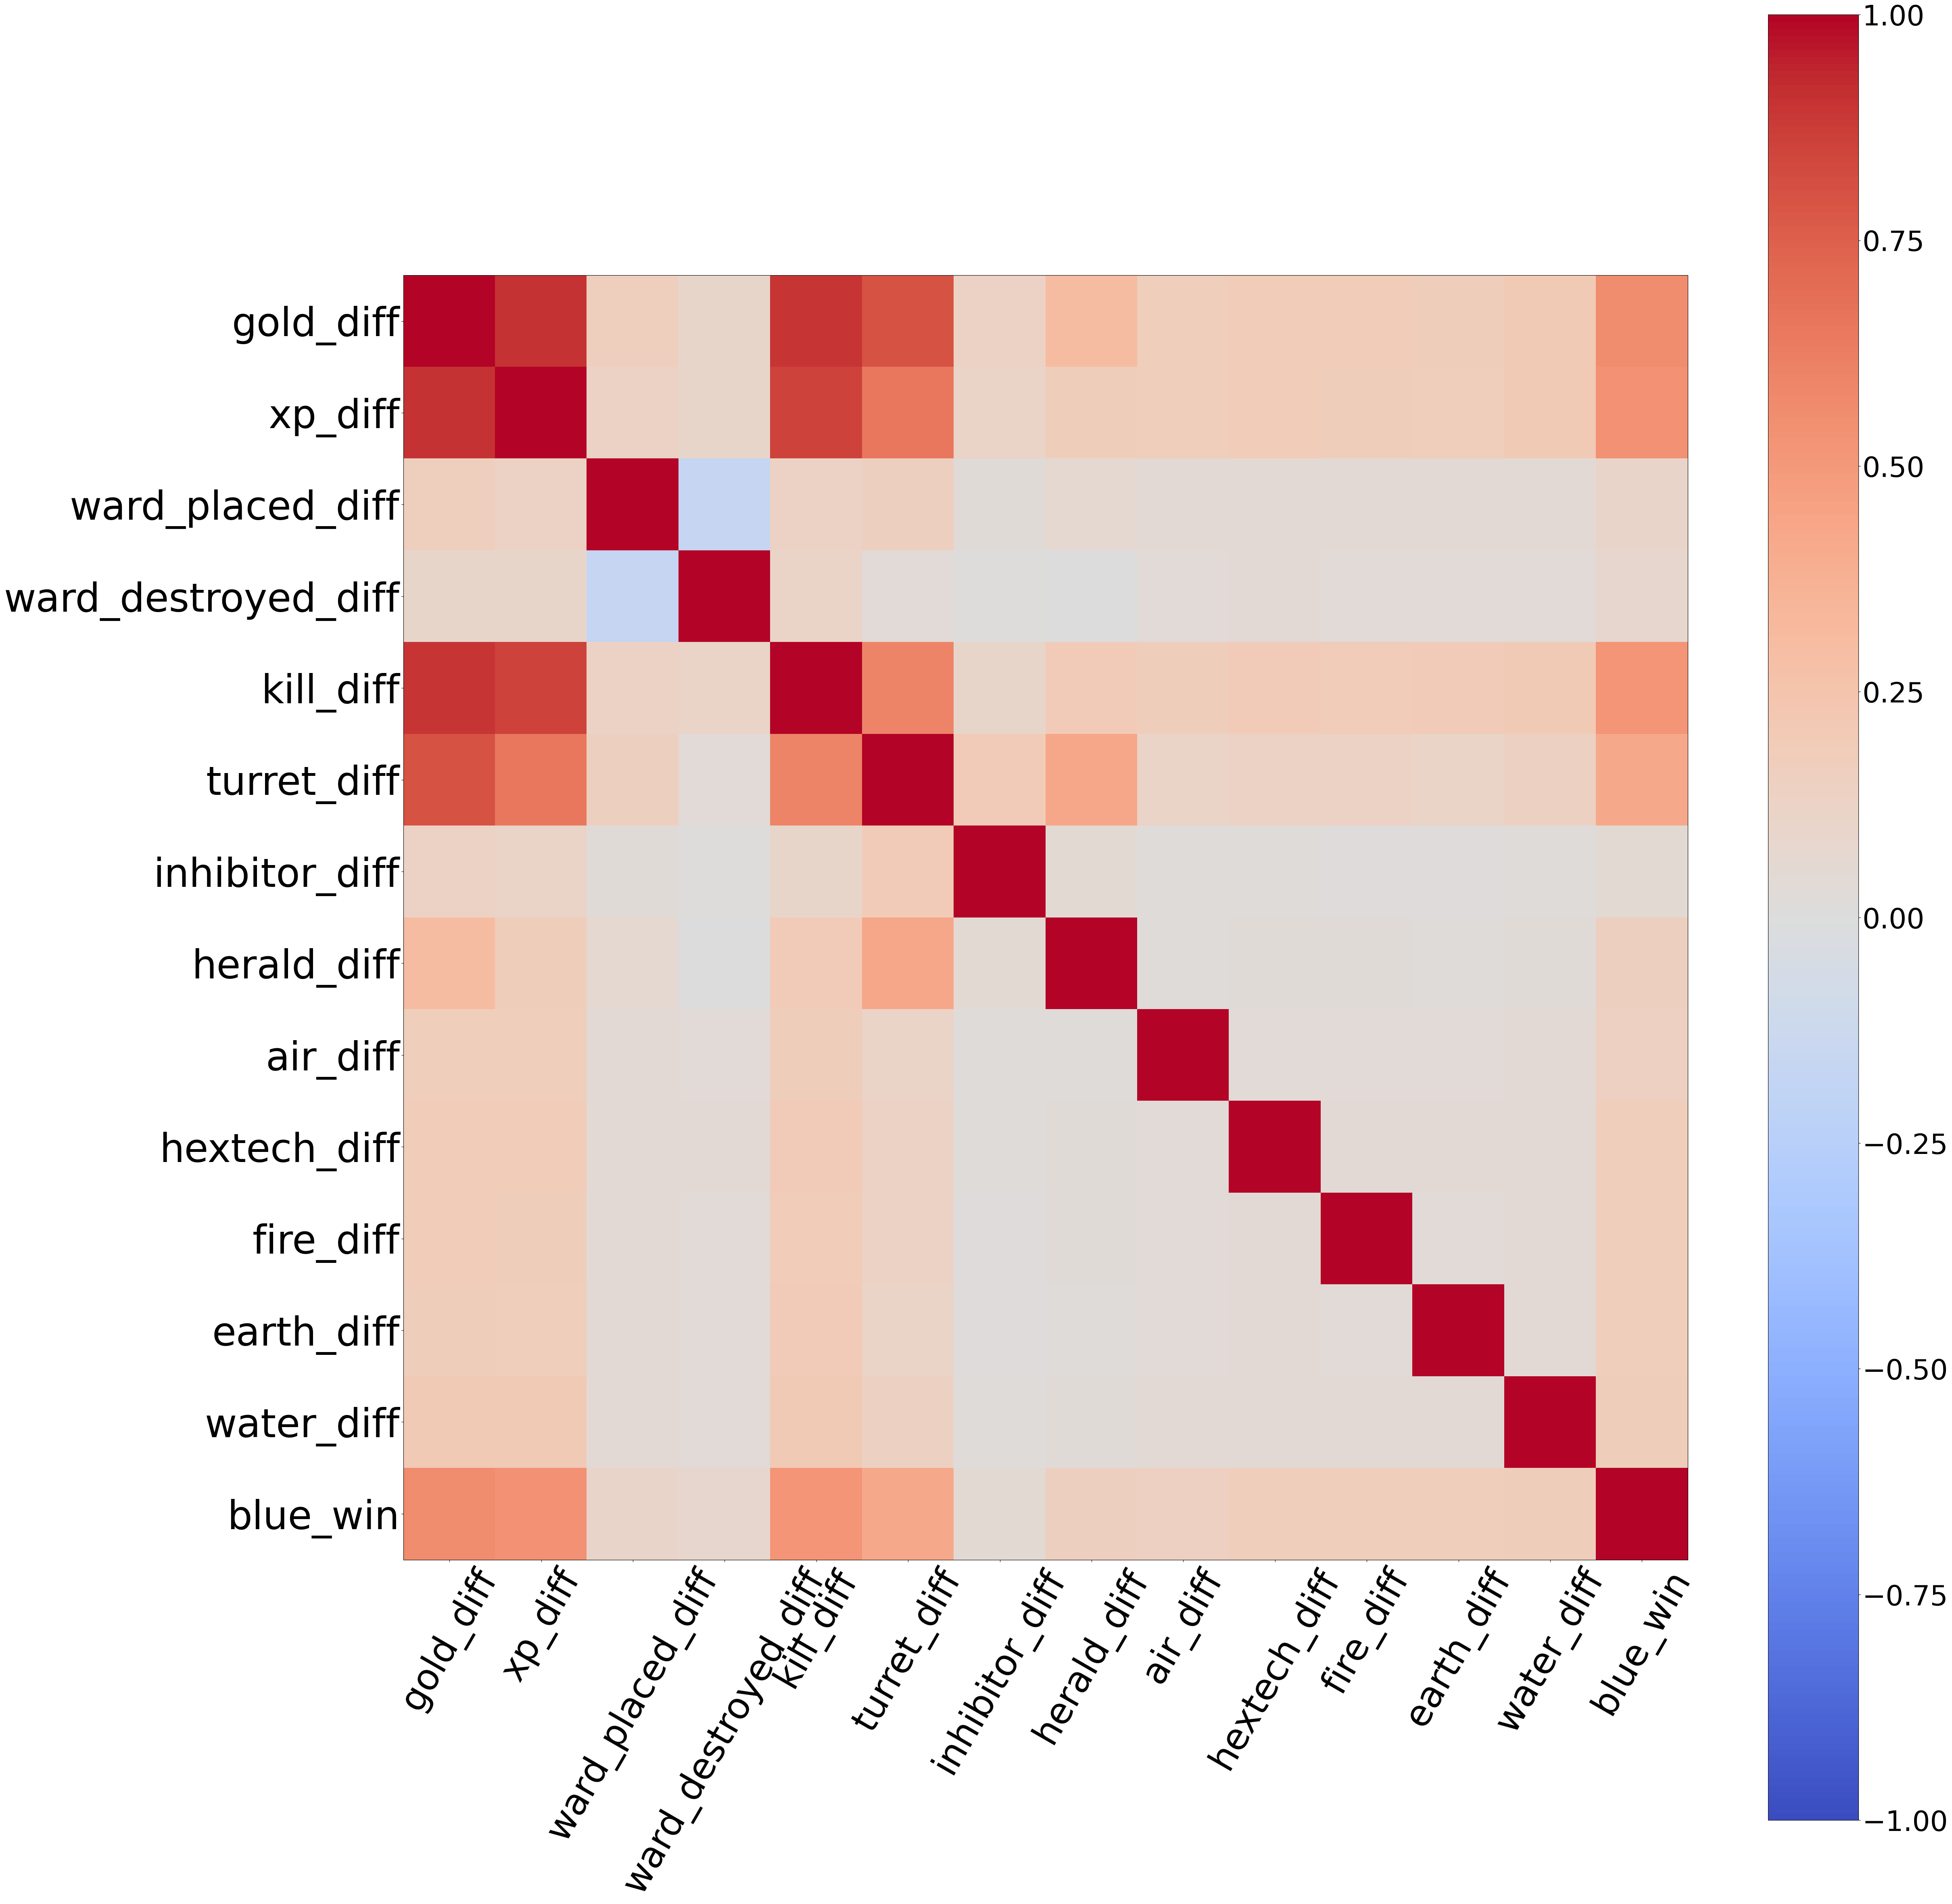

In [9]:
# I choose the relative value for correlation matrix 
diff_selected_columns = ['gold_diff','xp_diff','ward_placed_diff','ward_destroyed_diff','kill_diff','turret_diff','inhibitor_diff','herald_diff','air_diff','hextech_diff','fire_diff','earth_diff','water_diff','blue_win']
corr_matrix=df[diff_selected_columns].corr(method='pearson')
plt.figure(figsize=(50,50))
plt.imshow(corr_matrix,cmap='coolwarm',vmin=-1, vmax=1)
plt.xticks(fontsize=65,rotation=60) 
plt.yticks(fontsize=70)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=50)
plt.savefig('Heatmap.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

### 2. Dragons features 

blue_win                0      1
total_Dragons_diff              
-2                  17485   6419
-1                  12725   8264
 0                  14973  15979
 1                   7106  12422
 2                   5060  16257
blue_win                   0         1
total_Dragons_diff                    
-2                  0.731468  0.268532
-1                  0.606270  0.393730
 0                  0.483749  0.516251
 1                  0.363888  0.636112
 2                  0.237369  0.762631


<function matplotlib.pyplot.show(close=None, block=None)>

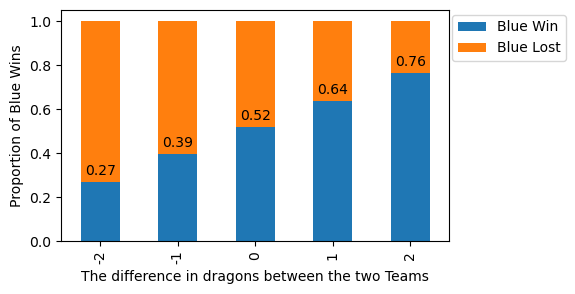

In [12]:
df['total_Dragons_diff'] = df['air_diff'] + df['hextech_diff'] + df['fire_diff'] + df['earth_diff']+df['water_diff']

count_matrix = df.groupby(['total_Dragons_diff', 'blue_win']).size().unstack()
print(count_matrix)

count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
print(count_matrix_norm)
ax=count_matrix_norm[[1,0]].plot(kind='bar', stacked=True,figsize=(5,3))
patches = plt.gca().patches

for i in range(len(count_matrix_norm)):
    y_value = count_matrix_norm.iloc[i, 1]
    x_pos = i  
    plt.text(x_pos, y_value + 0.02, f'{y_value:.2f}', 
             ha='center', va='bottom', fontsize=10, color='black')
plt.xlabel('The difference in dragons between the two Teams')
plt.ylabel('Proportion of Blue Wins')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Blue Win', 'Blue Lost'], loc=4, bbox_to_anchor=(1.32, 0.75))  
plt.show

### 3. Ward feature

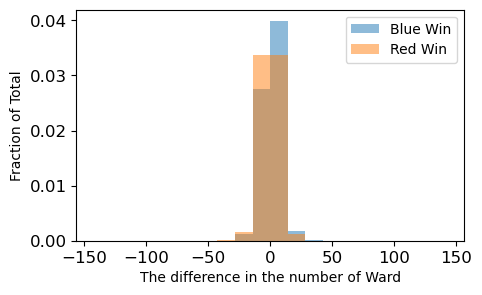

In [16]:
categories = df['blue_win'].unique()
max_abs = max(abs(df['ward_placed_diff'].min()), abs(df['ward_placed_diff'].max()))
bin_range = (-max_abs, max_abs)

plt.figure(figsize=(5,3))

legend_labels = {0: 'Red Win', 1: 'Blue Win'}
for c in categories:
    plt.hist(df[df['blue_win']==c]['ward_placed_diff'],alpha=0.5,label=legend_labels[c],range=bin_range,bins=20,density=True)
plt.legend()
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)
plt.ylabel('Fraction of Total')
plt.xlabel('The difference in the number of Ward')
plt.savefig('Ward_placed.png', dpi=300, bbox_inches='tight')
plt.show()


## CV pipeline

### 1. Preprocess

In [19]:
ordinal_ftrs = ['first_blood','first_turret','first_inhibitor','first_herald','first_baron']

std_ftrs = ['blue_gold','red_gold','gold_diff','blue_xp','red_xp','xp_diff','blue_ward_placed','red_ward_placed','ward_placed_diff','blue_ward_destroyed','red_ward_destroyed','ward_destroyed_diff','blue_kills','red_kills','kill_diff','blue_turrets','red_turrets','turret_diff','blue_inhibitors','red_inhibitors','inhibitor_diff','blue_heralds','red_heralds','herald_diff','blue_barons','red_barons','baron_diff','blue_air','red_air','air_diff','blue_hextech','red_hextech','hextech_diff','blue_fire','red_fire','fire_diff','blue_earth','red_earth','earth_diff','blue_water','red_water','water_diff']

preprocessor = ColumnTransformer(
    transformers=[
        ('std', StandardScaler(), std_ftrs)])

### 2. CV pipeline

In [22]:
def MLpipe_KFold_prec(X, y, preprocessor, ML_algo, param_grid):
    
    # lists to be returned 
    test_scores = []
    best_models = []

    #  1. Loop through 10 different random states
    for i in range(10):
        
    #   2. Split your data 
        X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2,random_state=i)

    #  3. Fit a model using GridSearchCV with KFold and the predefined Preprocessor
        kfold = KFold(n_splits=4, shuffle=True, random_state=i)

        clf=ML_algo(random_state=i)
        
        pipe=make_pipeline(preprocessor,clf)

        grid=GridSearchCV(pipe, param_grid, cv=kfold, return_train_score = True,scoring='precision', n_jobs=-1, verbose=True)
        grid.fit(X_other, y_other)

        print(f"Iteration {i + 1}:")
        print('best model hyperparameters:',grid.best_params_)
        print('validation score:',grid.best_score_) 
        
        # save the model
        best_models.append(grid.best_estimator_)

    # 4. Calculate the model's error on the test set 
        y_test_pred = grid.predict(X_test)
        prec= precision_score(y_test,y_test_pred)
        test_scores.append(prec)
        print('Test score:', prec)

    return best_models, test_scores

### 3. Logistic 

In [ ]:
from sklearn.linear_model import LogisticRegression

ML_algo=LogisticRegression

param_grid = {
    'logisticregression__penalty':['elasticnet'],
    'logisticregression__C' : np.logspace(-4, 4, 5),
    'logisticregression__solver':['saga'],
    'logisticregression__max_iter':[100000000],
    'logisticregression__n_jobs':[-1],
    'logisticregression__l1_ratio':[0, 0.4, 0.8, 1]

}

best_models, test_scores= MLpipe_KFold_prec(X, y, preprocessor, ML_algo, param_grid)

mean_prec = np.mean(test_scores)
std_prec = np.std(test_scores)
print('Mean precision:', mean_prec)
print('Standard Deviation of precision:', std_prec)

### 4. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

ML_algo=RandomForestClassifier

param_grid = {
    'randomforestclassifier__n_estimators': [100], 
    'randomforestclassifier__max_depth': [1, 10, 100], 
    'randomforestclassifier__max_features': [0.5,1.0],
    'randomforestclassifier__n_jobs':[-1]
} 

best_models, test_scores= MLpipe_KFold_prec(X, y, preprocessor, ML_algo, param_grid)

mean_prec = np.mean(test_scores)
std_prec = np.std(test_scores)
print('Mean precision:', mean_prec)
print('Standard Deviation of precision:', std_prec)

### 5. KNeighborsRegressor

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'kneighborsclassifier__n_neighbors': [1, 3, 5],
    'kneighborsclassifier__weights': ['uniform', 'distance']
}

test_scores = []
best_models = []

    #  1. Loop through 10 different random states
for i in range(10):
        
    #   2. Split your data 
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2,random_state=i)

    #  3. Fit a model using GridSearchCV with KFold and the predefined Preprocessor
    kfold = KFold(n_splits=4, shuffle=True, random_state=i)

    clf=KNeighborsClassifier()
        
    pipe=make_pipeline(preprocessor,clf)

    grid=GridSearchCV(pipe, param_grid, cv=kfold, return_train_score = True,scoring='precision', n_jobs=-1, verbose=True)
    grid.fit(X_other, y_other)

    print(f"Iteration {i + 1}:")
    print('best model hyperparameters:',grid.best_params_)
    print('validation score:',grid.best_score_) 

    # save the model
    best_models.append(grid.best_estimator_)
    y_test_pred = grid.predict(X_test)
    prec= precision_score(y_test,y_test_pred)
    test_scores.append(prec)
    print('Test score:', prec)


mean_prec = np.mean(test_scores)
std_prec = np.std(test_scores)
print('Mean precision:', mean_prec)
print('Standard Deviation of precision:', std_prec)

### 6. XGBoost

In [66]:
import xgboost
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.metrics import precision_score
from sklearn.preprocessing import StandardScaler
import numpy as np

param_grid = {
    "learning_rate": [0.03],
    "n_estimators": [1000],
    "colsample_bytree": [0.9],
    "subsample": [0.66],
    "reg_alpha": [1e0, 1e1,1e2],
    "reg_lambda": [1e0, 1e1, 1e2],
    "max_depth": [1, 10, 100]
}


validation_scores = []
test_scores = []


for random_state in range(10):
    print(f"Random State {random_state + 1}:\n")
    

    X_other, X_test, y_other, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_state
    )

    X_train, X_val, y_train, y_val = train_test_split(
            X_other, y_other, test_size=0.2, random_state=random_state
        )
        
    scaler = StandardScaler()
    df_train = scaler.fit_transform(X_train)
    df_val = scaler.transform(X_val)
    df_test = scaler.transform(X_test)
    
    best_val_score = 0
    best_test_score = 0

    for params in ParameterGrid(param_grid):
        
        XGB = xgboost.XGBClassifier()
        XGB.set_params(**params, early_stopping_rounds=50,)

        XGB.fit(df_train, y_train,eval_set=[(df_val, y_val)],verbose=False)
        

        y_val_pred = XGB.predict(df_val)
        precision_val = precision_score(y_val, y_val_pred)

        y_test_pred = XGB.predict(df_test)
        precision_test = precision_score(y_test, y_test_pred)
        

        if precision_val > best_val_score:
            best_val_score = precision_val
            best_test_score = precision_test
            best_params = params


    validation_scores.append(best_val_score)
    test_scores.append(best_test_score)

    print(f"Best Validation Precision (Random State {random_state + 1}): {best_val_score:.4f}")
    print(f"Best Test Precision (Random State {random_state + 1}): {best_test_score:.4f}\n")
    print(f"Best Parameters (Random State {random_state + 1}): {best_params}\n")

mean_test_precision = np.mean(test_scores)
std_test_precision=np.std(test_scores)

print("=== Final Results ===")
print(f"Mean Test Precision over 10 random states: {mean_test_precision:.4f}")
print(f"Standard Deviation of precision over 10 random states: {std_test_precision:.4f}")

Random State 1:

Best Validation Precision (Random State 1): 0.7642
Best Test Precision (Random State 1): 0.7574

Best Parameters (Random State 1): {'colsample_bytree': 0.9, 'learning_rate': 0.03, 'max_depth': 1, 'n_estimators': 1000, 'reg_alpha': 1.0, 'reg_lambda': 10.0, 'subsample': 0.66}

Random State 2:

Best Validation Precision (Random State 2): 0.7623
Best Test Precision (Random State 2): 0.7687

Best Parameters (Random State 2): {'colsample_bytree': 0.9, 'learning_rate': 0.03, 'max_depth': 1, 'n_estimators': 1000, 'reg_alpha': 1.0, 'reg_lambda': 10.0, 'subsample': 0.66}

Random State 3:

Best Validation Precision (Random State 3): 0.7647
Best Test Precision (Random State 3): 0.7672

Best Parameters (Random State 3): {'colsample_bytree': 0.9, 'learning_rate': 0.03, 'max_depth': 1, 'n_estimators': 1000, 'reg_alpha': 10.0, 'reg_lambda': 100.0, 'subsample': 0.66}

Random State 4:

Best Validation Precision (Random State 4): 0.7641
Best Test Precision (Random State 4): 0.7562

Best 

### 7. Extra trees

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

ML_algo=ExtraTreesClassifier

param_grid = {
    'extratreesclassifier__max_depth': [1, 10, 100], 
    'extratreesclassifier__max_features': [0.5,1.0],
    'extratreesclassifier__n_jobs':[-1]
} 


best_models, test_scores= MLpipe_KFold_prec(X, y, preprocessor, ML_algo, param_grid)

mean_prec = np.mean(test_scores)
std_prec = np.std(test_scores)
print('Mean precision:', mean_prec)
print('Standard Deviation of precision:', std_prec)

## Result

### 1. baseline result

In [67]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

test_scores=[]

for i in range(10):
        
    #   2. Split your data 
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2,random_state=i)

    #  3. Fit a model using GridSearchCV with KFold and the predefined Preprocessor
    kfold = KFold(n_splits=4, shuffle=True, random_state=i)
    for train_index, val_index in kfold.split(X_other,y_other):
        X_train = X_other.iloc[train_index]
        y_train = y_other.iloc[train_index]
        X_val = X_other.iloc[val_index]
        y_val = y_other.iloc[val_index]

    clf=DummyClassifier(strategy='most_frequent',random_state=i)
        
    pipe=make_pipeline(preprocessor,clf)

    clf.fit(X_train, y_train)
    
    print(f"Iteration {i + 1}:")
    y_pred_baseline = clf.predict(X_test)
    prec= precision_score(y_test, y_pred_baseline)
    test_scores.append(prec)
    print('Test score:', prec)


mean_prec = np.mean(test_scores)
std_prec = np.std(test_scores)
print('Mean precision:', mean_prec)
print('Standard Deviation of precision:', std_prec)

Iteration 1:
Test score: 0.5049704344845317
Iteration 2:
Test score: 0.5085697146285029
Iteration 3:
Test score: 0.5131116633816094
Iteration 4:
Test score: 0.5092124432256406
Iteration 5:
Test score: 0.5084840174822178
Iteration 6:
Test score: 0.5071557117147999
Iteration 7:
Test score: 0.5106692947124861
Iteration 8:
Test score: 0.5098980203959208
Iteration 9:
Test score: 0.5105407489930586
Iteration 10:
Test score: 0.5115691147484789
Mean precision: 0.5094181163767246
Standard Deviation of precision: 0.002187695576262382


best model hyperparameters: {'randomforestclassifier__max_depth': 100, 'randomforestclassifier__max_features': 0.5, 'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__n_jobs': -1}

In [68]:
random_state=42

    # create a test set
X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    
# splitter for _other
kf = KFold(n_splits=4,shuffle=True,random_state=random_state)
for train_index, val_index in kf.split(X_other,y_other):
        X_train = X_other.iloc[train_index]
        y_train = y_other.iloc[train_index]
        X_val = X_other.iloc[val_index]
        y_val = y_other.iloc[val_index]

ordinal_ftrs = ['first_blood','first_turret','first_inhibitor','first_herald','first_baron']

std_ftrs = ['blue_gold','red_gold','gold_diff','blue_xp','red_xp','xp_diff','blue_ward_placed','red_ward_placed','ward_placed_diff','blue_ward_destroyed','red_ward_destroyed','ward_destroyed_diff','blue_kills','red_kills','kill_diff','blue_turrets','red_turrets','turret_diff','blue_inhibitors','red_inhibitors','inhibitor_diff','blue_heralds','red_heralds','herald_diff','blue_barons','red_barons','baron_diff','blue_air','red_air','air_diff','blue_hextech','red_hextech','hextech_diff','blue_fire','red_fire','fire_diff','blue_earth','red_earth','earth_diff','blue_water','red_water','water_diff']

preprocessor = ColumnTransformer(
        transformers=[
        ('std', StandardScaler(), std_ftrs)])


In [69]:
# fit_transform the training set
X_prep = preprocessor.fit_transform(X_train)
# little hacky, but collect feature names
feature_names = preprocessor.get_feature_names_out()

df_train = pd.DataFrame(data=X_prep,columns=feature_names)
print(f'preprocessed train size: {df_train.shape}')

# transform the CV
df_CV = preprocessor.transform(X_val)
df_CV = pd.DataFrame(data=df_CV,columns = feature_names)
print(f'preprocessed validation size: {df_CV.shape}')

# transform the test
df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=df_test,columns = feature_names)
print(f'preprocessed test size: {df_test.shape}')

preprocessed train size: (70014, 42)
preprocessed validation size: (23338, 42)
preprocessed test size: (23338, 42)


In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import precision_score


# parameters to try 
param_grid = {"max_depth": [100],
              "max_features": [0.5],
              "n_estimators": [100],
              "n_jobs": [-1]
}


# create xgboost model and set parameters 
clf= RandomForestClassifier()
clf.set_params(**ParameterGrid(param_grid)[0])

# fit model to train data 
clf.fit(df_train,y_train)

# predict on validation 
y_val_pred = clf.predict(df_CV)
print('the CV precesion:',precision_score(y_val,y_val_pred))

# predict on test 
y_test_pred = clf.predict(df_test)
print('the test precesion:',precision_score(y_test,y_test_pred))

the CV precesion: 0.7640013495276653
the test precesion: 0.7640373768835761


### 2. Random Forest

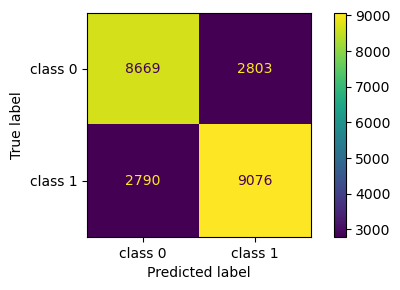

In [75]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test,y_test_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=['class 0', 'class 1'])
fig, ax = plt.subplots(figsize=(5,3))
disp.plot(ax=ax)
plt.tight_layout()
plt.savefig('confusion.png', dpi=300, bbox_inches='tight')  
plt.show()



### 3. permutation_importance

In [76]:
from sklearn.inspection import permutation_importance
result = permutation_importance(clf, df_test, y_test, n_repeats=10, scoring='precision' ,random_state=42, n_jobs=-1)
importance_values = result.importances_mean

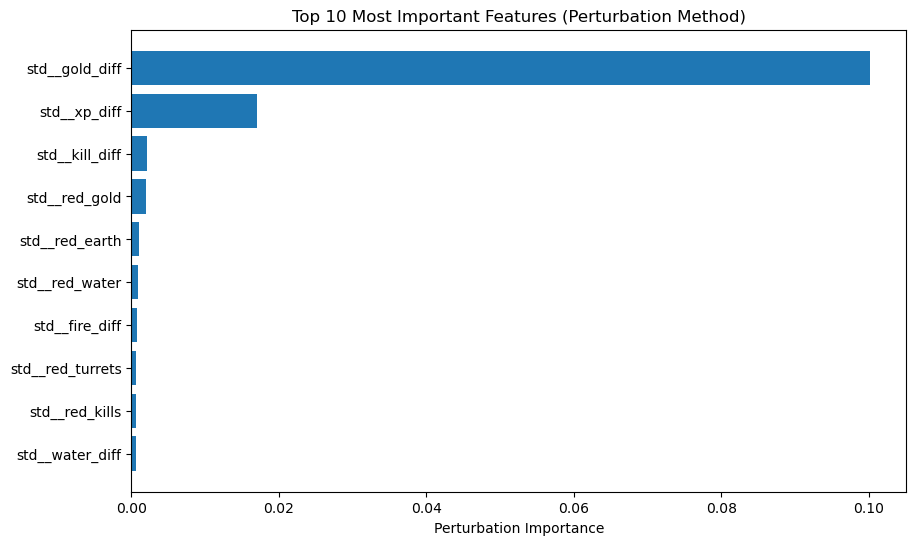

In [78]:
# your code here
import matplotlib.pyplot as plt
import pandas as pd

feature_importance = pd.DataFrame({
    'Feature': feature_names ,
    'Importance': importance_values
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Perturbation Importance')
plt.title('Top 10 Most Important Features (Perturbation Method)')
plt.gca().invert_yaxis() 
#plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight') 
plt.show()

### 4. SHAP global importance

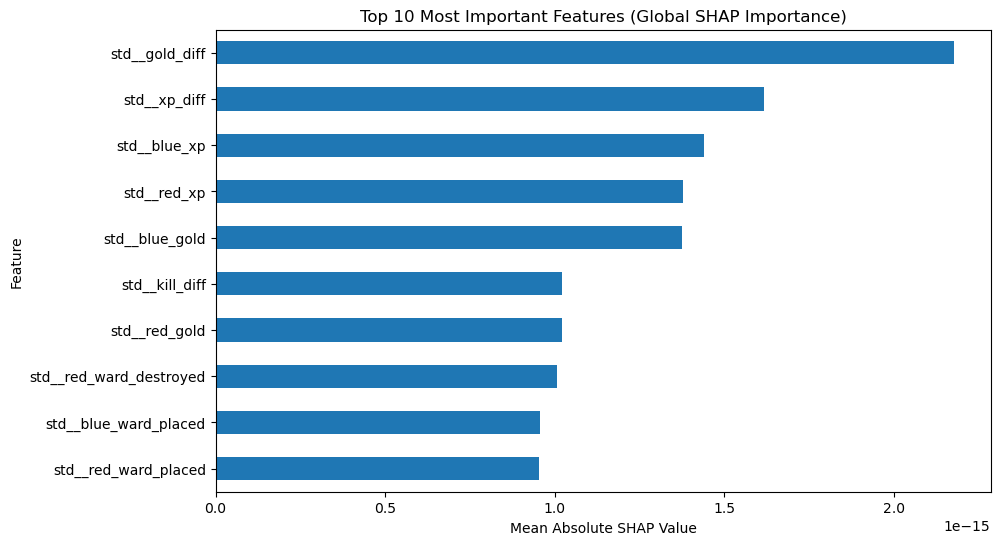

In [79]:
import shap
explainer = shap.TreeExplainer(clf)

shap_values = explainer.shap_values(df_test)

if isinstance(shap_values, list):  
    shap_values_combined = np.mean(np.abs(shap_values), axis=0)
else:  
    shap_values_combined = np.mean(shap_values, axis=2) if shap_values.ndim == 3 else shap_values


shap_df = pd.DataFrame(shap_values_combined, columns=feature_names )

shap_importance = shap_df.abs().mean(axis=0).sort_values(ascending=False)

top_10_features = shap_importance.head(10)

plt.figure(figsize=(10, 6))
top_10_features.plot(kind='barh')
plt.title('Top 10 Most Important Features (Global SHAP Importance)')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Feature')
plt.gca().invert_yaxis() 

### 5. Mean Decrease in Impurity

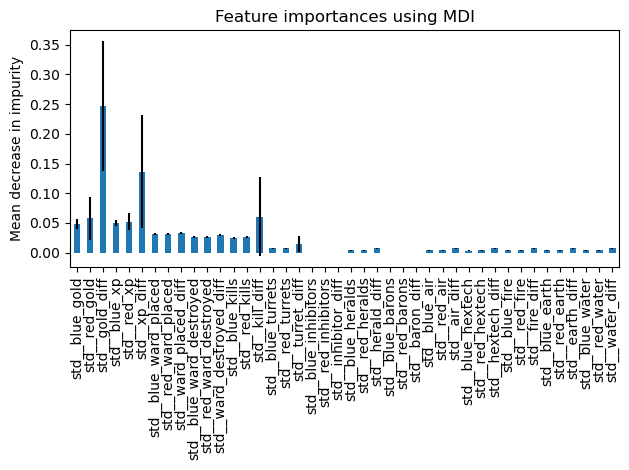

In [81]:
import numpy as np
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
import pandas as pd

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### 6. Local feature importance

In [88]:
index= 100
if isinstance(shap_values, list):

    class_index = 1 
    base_value = explainer.expected_value[class_index]
    shap_values_for_class = shap_values[class_index][index]
    
 
    shap.force_plot(
        base_value=base_value,
        shap_values=shap_values_for_class,
        features=df_test.iloc[index],
        feature_names=feature_names
    )
    

    shap.save_html(
        "shap_force_plot_class1.html",
        shap.force_plot(
            base_value=base_value,
            shap_values=shap_values_for_class,
            features=df_test.iloc[index],
            feature_names=feature_names
        )
    )
elif shap_values.ndim == 3:
 
    output_index = 0 
    base_value = explainer.expected_value[output_index]
    shap_values_for_output = shap_values[index, :, output_index]
    

    shap.force_plot(
        base_value=base_value,
        shap_values=shap_values_for_output,
        features=df_test.iloc[index],
        feature_names=feature_names
    )
    

    shap.save_html(
        "shap_force_plot_output1.html",
        shap.force_plot(
            base_value=base_value,
            shap_values=shap_values_for_output,
            features=df_test.iloc[index],
            feature_names=feature_names
        )
    )
else:

    base_value = explainer.expected_value
    shap_values_for_sample = shap_values[index]
    

    shap.force_plot(
        base_value=base_value,
        shap_values=shap_values_for_sample,
        features=df_test.iloc[index],
        feature_names=feature_names
    )
    
    shap.save_html(
        "shap_force_plot.html",
        shap.force_plot(
            base_value=base_value,
            shap_values=shap_values_for_sample,
            features=df_test.iloc[index],
            feature_names=feature_names
        )
    )
